In [1]:
import wordle
import matplotlib.pyplot as plt
import numpy as np
from random import choice

## Baseline

To establish a baseline, let's see how well we do playing a random word for each guess, subject to the condition that the word match all previous clues. This will converge as each clue limits the number of remaining options - in the worst possible case we end up with a set of anagrams from which we draw randomly until getting the right answer.

In [5]:
N = 1000
rows = np.zeros(N, dtype='int')
for i in range(N):
    soln = choice(wordle.corpus)
    game = wordle.Wordle(soln)
    solver = wordle.RandomSolver()
    rows[i] = game.autoplay(solver)

In [3]:
def plot_results(rows):
    # Histogram
    fig, ax = plt.subplots()
    ax.hist(rows, bins=list(range(1, max(rows))), density=True)
    ax.set_title('Solution Distribution')
    plt.show()
    # Statistics:
    print(f"Winning percentage: \t\t{np.sum(rows < 7)/N :5.2%}")
    print(f"3-row (or better) percentage: \t{np.sum(rows <= 3)/N :5.2%}")
    print(f"Average number of guesses: \t{np.mean(rows) :5.2f}")
    print(f"Median number of guesses: \t{np.median(rows) :5.2f}")
    print(f"Best game: \t\t\t{np.min(rows) :5d}")

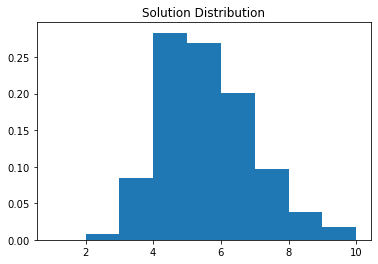

Winning percentage: 		84.60%
3-row (or better) percentage: 	9.30%
Average number of guesses: 	 5.12
Median number of guesses: 	 5.00
Best game: 			    2


In [6]:
plot_results(rows)

This is actually pretty good! Of course, some percentage of the time there is a lucky guess (we could keep track of how many words were in the list when each guess was made to check this), but this shows that simply playing words matching the known clues reduces the possibilities to a singleton quickly enough to win most of the time.

## Probabilistic Approach

The most obvious actual _strategy_ is to play words which uses more probable letters like "e" and "t" first. If we can eliminate one of these letters, than that reduces the word list more quickly than eliminating a less-common letter like "j". They are also more likely to be right, and right guesses reduce the word list faster than wrong ones.

 The naïve way to get the most-probably word is to define $P(\alpha)$ by the number of occurrences of the letter $\alpha$ in our corpus of words, divided by the total number of letters. Then we want to maximize the objective function:

$$
F\left(\{\alpha_i\}_{i=1}^5\right) = \prod_{i=1}^5 P(\alpha_i)
$$

over all sequences of five letters in our corpus of words. The `MaxLikelihoodEstimator` implements this strategy.

In [8]:
N = 1000
rows = np.zeros(N, dtype='int')
for i in range(N):
    soln = choice(wordle.corpus)
    game = wordle.Wordle(soln)
    solver = wordle.MaxLikelihoodSolver()
    rows[i] = game.autoplay(solver)

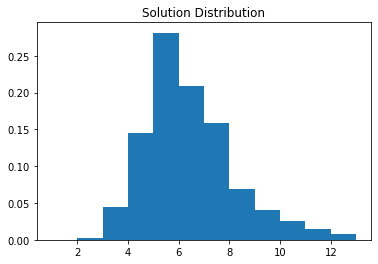

Winning percentage: 		68.30%
3-row (or better) percentage: 	4.80%
Average number of guesses: 	 5.93
Median number of guesses: 	 6.00
Best game: 			    2


In [9]:
plot_results(rows)

This performs _worse_ than random chance! Why? Let's step through a game and see:

In [10]:
game = wordle.Wordle('scant', verbose=True)
solver = wordle.MaxLikelihoodSolver()
game.autoplay(solver)

Correct! Puzzle completed in 5 guesses.
Guesses: ['areae', 'salsa', 'stats', 'suant', 'scant']
Clues: [[-1, 0, 0, 0, 0], [1, -1, 0, 0, 0], [1, -1, 1, 0, 0], [1, 0, 1, 1, 1], [1, 1, 1, 1, 1]]


5

The pattern here is pretty typical - letters like "e" and "a" are common, so the solver chooses words that uses them as much as possible, like "areae" (apparently a valid Scrabble play, but not really a normal word). But these words don't produces as much information gain as something like "rates" because they don't have as many distinct letters.

We need to improve our model of probabilities beyond just "frequency in the corpus". Or we need an objective function that takes information content into account.